# Capstone Project: Battle of Neighborhoods in Vancouver - Data Section

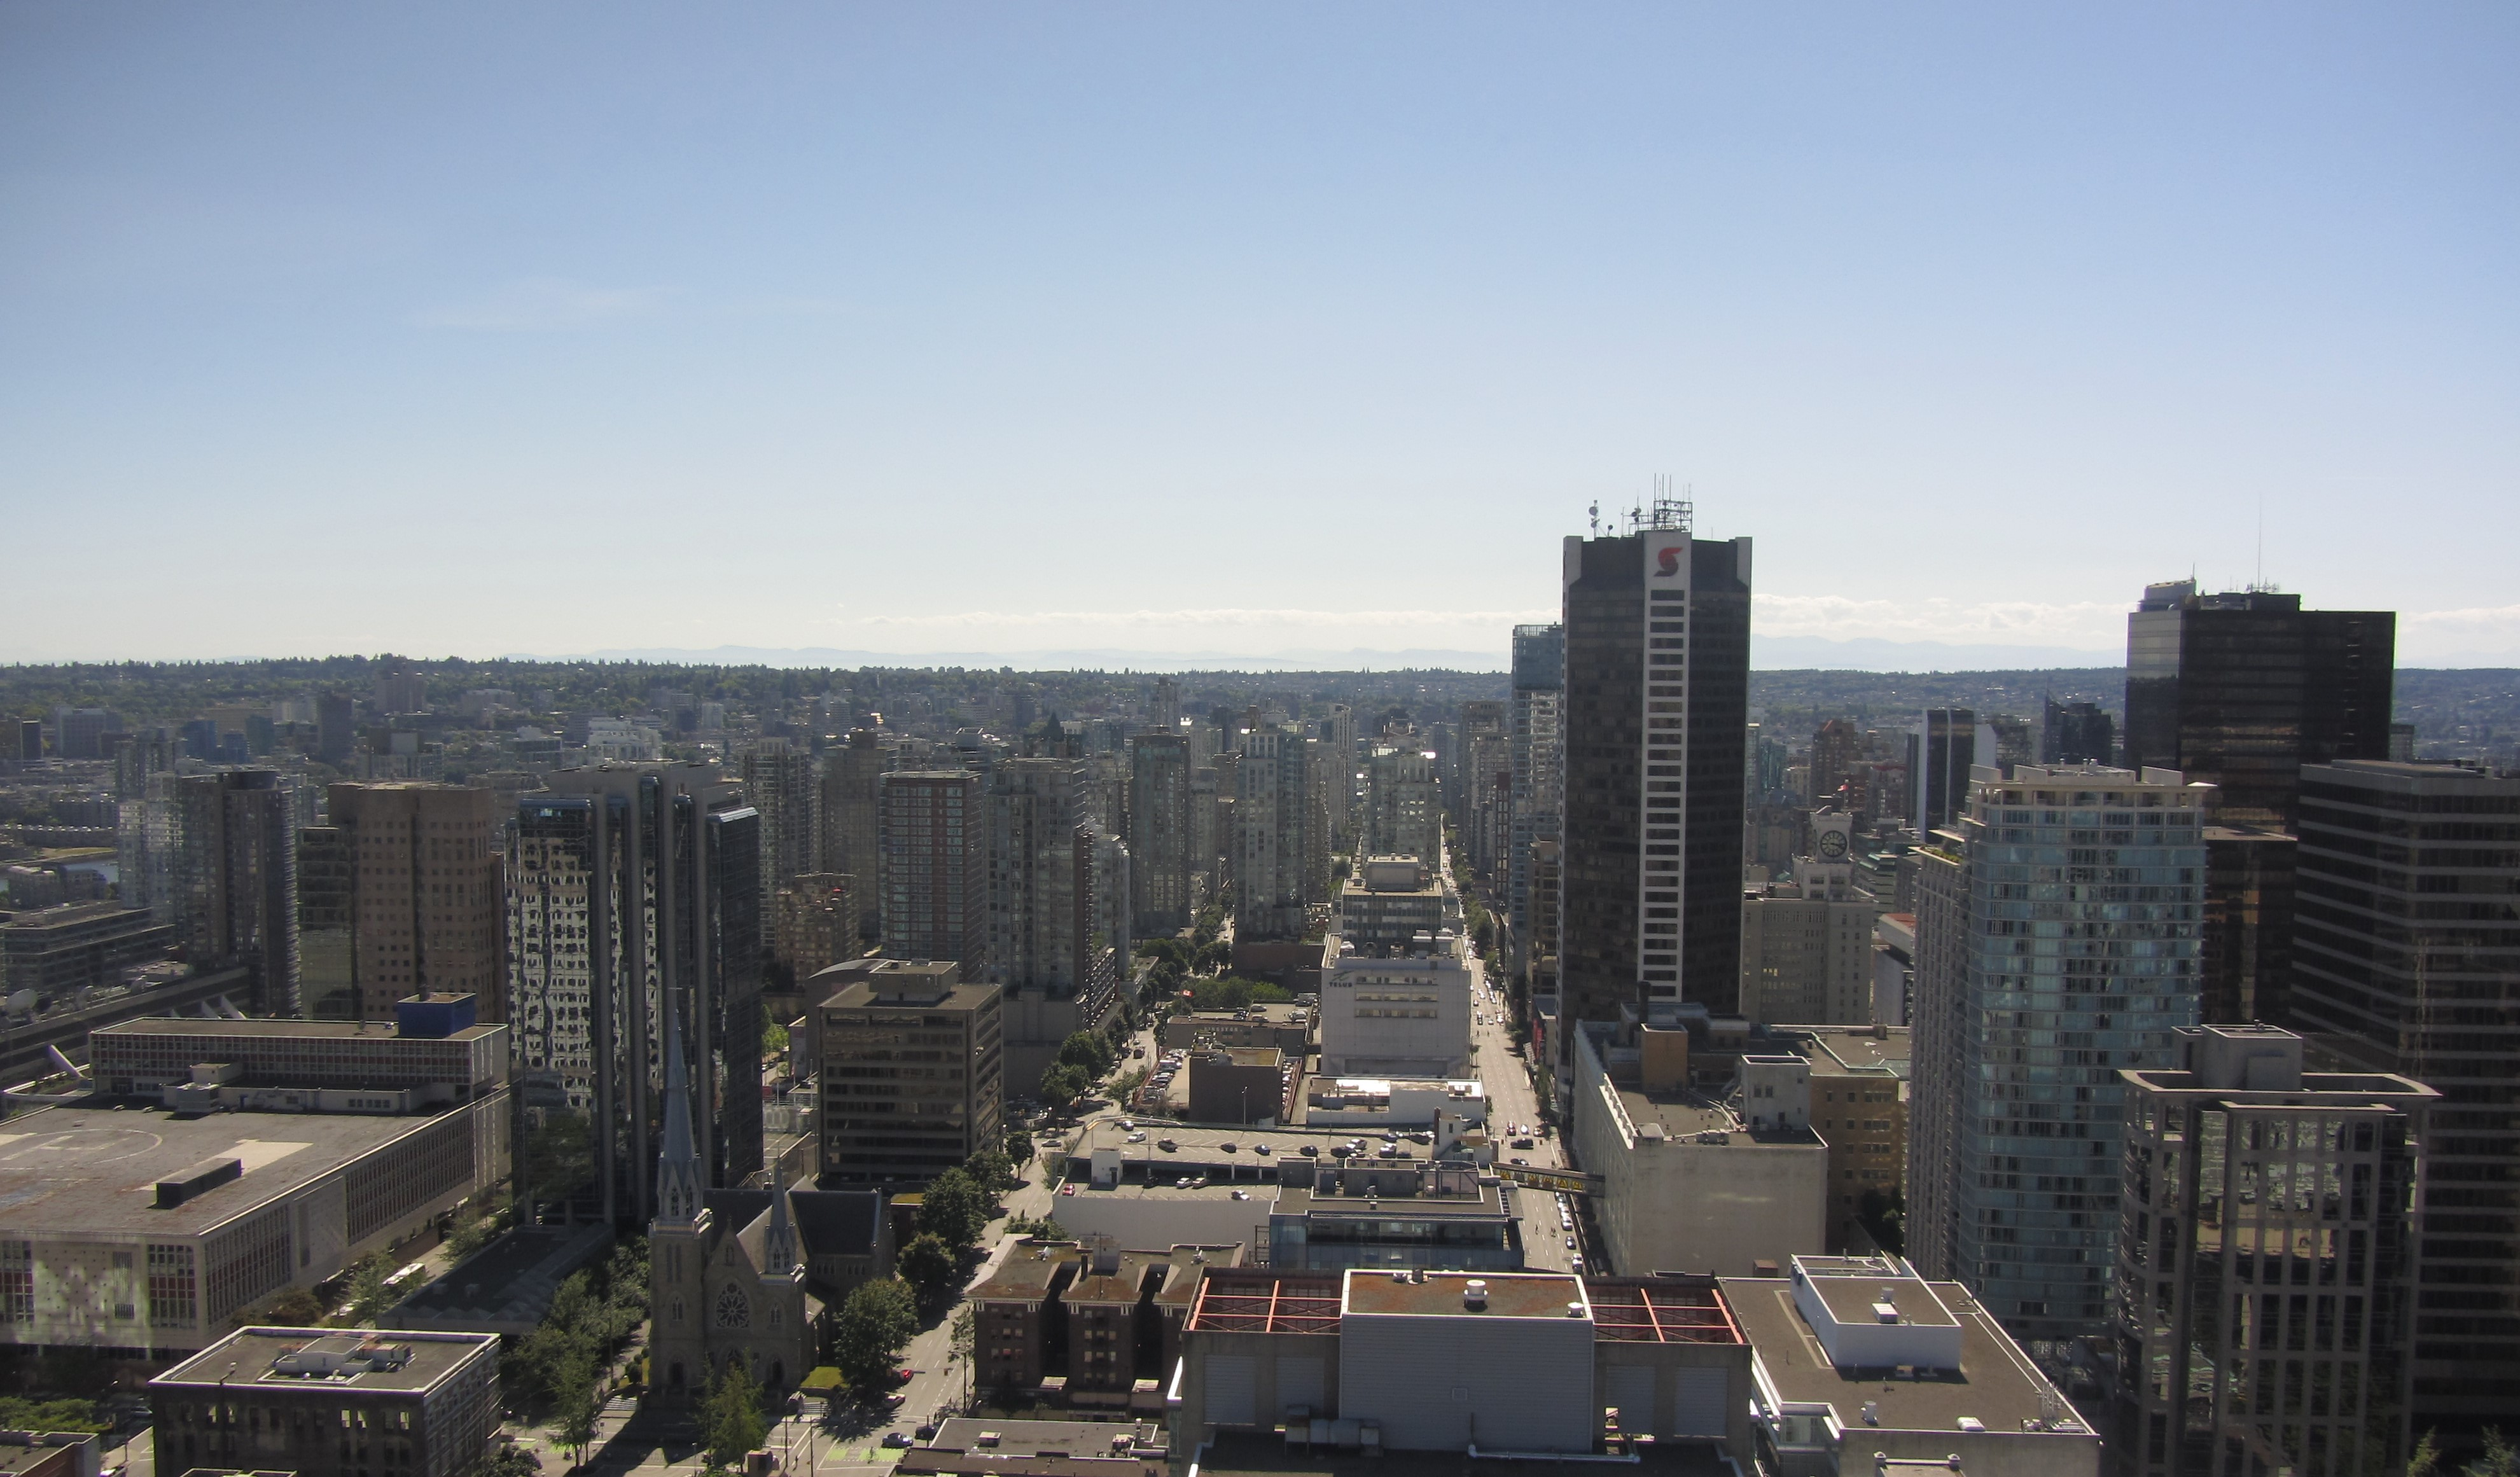

Now, let's collect the data! The first step of the Vancouver Battle of the Neighborhoods analysis is retrieving Vancouver Geo Data. I retrieve the Vancouver Geo Data from *'Geo Names'*. This website includes postal code data from various countries worldwide. Aside from postal code data, geospatial data is available. You can dowload a zip file from the website; the zip file includes a text file. A more challenging way is to access the data by the web url, read the text file data, doing some data cleaning, and finally, save the data as a csv file in my documents folder.<br>
<br>
After collecting postal code and geospatial data, I gather data on housing prices and crime data. The data on housing prices is retrieved from the Vancouver Open Source Portal. The data was available in csv format. Also, the Vancouver crime data was available in csv format at the release of Vancouver Police Department (VPD) crime data website.

So, summarizing, I collect the data from the following sources:<br>
<br>
Vancouver Geo Data from Geo Names <br>
(including postal codes, neighborhoods, latitudes, longitudes):               
http://download.geonames.org/export/zip/CA.zip <br>
<br>
Property Price Data Vancouver Dwellings:<br>
https://opendata.vancouver.ca/explore/dataset/property-tax-report/table/<br>
<br>
Vancouver Crime Data from the Vancouver Police Department:<br>
https://geodash.vpd.ca/opendata/<br>
<br>
Foursquare venue data on amenities in neighborhoods:<br>
https://foursquare.com/<br>
<br>
Vancouver GeoJSON:<br>
https://prototype.metabolismofcities.org/cities/vancouver/maps/boundaries/3642/

In [1]:
#import packages
import pandas as pd
import csv

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import requests # library to handle requests
import random # library for random number generation

# module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

import geocoder # import geocoder

import folium # plotting library

#for webscraping
from bs4 import BeautifulSoup 

from html_table_extractor.extractor import Extractor

# Transform a json file into a pandas data frame
from pandas.io.json import json_normalize #package for flattening json in pandas df


# Import k-means for clustering
from sklearn.cluster import KMeans

# Matplotlib associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#url and zip file retrieval
import urllib.request
import zipfile
import chardet


print("Packages installed and libraries imported.")

Packages installed and libraries imported.


------------------------------------------------------------------------------------------------------------------------------

### Postal Code and Geo Data for Vancouver

To avoid confusion and to provide a clear overview of the data I will be using, I split the data section into more notebooks. In the webscraping Vancouver geodata notebook, I retrieved the postal code and geospatial data from Geo Names. I readed the text file from the website url, I cleaned the data, and I converted the text file to a csv file. Now, I import the geo data csv file from my documents. <br>
<br>
Link to notebook is: 

In [2]:
geo_path = 'C:/Users/Lydia/Documents/Coursera/IBM - Data Science/capestone project/capstone project week 4/data collection/postal codes/CanadaPostalCodes.csv'
geo_data = pd.read_csv(geo_path)
geo_data.head(5)

,Postal_Code,Neighborhood,State,City,Latitude,Longitude
0,T0A,Eastern Alberta (St. Paul),Alberta,NaN,54.7660,-111.7174
1,T0B,Wainwright Region (Tofield),Alberta,NaN,53.0727,-111.5816
2,T0C,Central Alberta (Stettler),Alberta,NaN,52.1431,-111.6941
3,T0E,Western Alberta (Jasper),Alberta,NaN,53.6758,-115.0948
4,T0G,North Central Alberta (Slave Lake),Alberta,NaN,55.6993,-114.4529


In [3]:
geo_data = geo_data[geo_data.City == 'Vancouver']   #select Vancouver data only

In [4]:
geo_data.head(10)

,Postal_Code,Neighborhood,State,City,Latitude,Longitude
154,V5K,Vancouver (North Hastings-Sunrise),British Columbia,Vancouver,49.2807,-123.0397
155,V5L,Vancouver (North Grandview-Woodlands),British Columbia,Vancouver,49.2795,-123.0667
156,V5M,Vancouver (South Hastings-Sunrise / North Renf...,British Columbia,Vancouver,49.2600,-123.0398
157,V5N,Vancouver (South Grandview-Woodlands / NE Kens...,British Columbia,Vancouver,49.2551,-123.0667
158,V5P,Vancouver (SE Kensington / Victoria-Fraserview),British Columbia,Vancouver,49.2220,-123.0683
159,V5R,Vancouver (South Renfrew-Collingwood),British Columbia,Vancouver,49.2397,-123.0407
160,V5S,Vancouver (Killarney),British Columbia,Vancouver,49.2175,-123.0380
161,V5T,Vancouver (East Mount Pleasant),British Columbia,Vancouver,49.2620,-123.0923
162,V5V,Vancouver (West Kensington / NE Riley Park-Lit...,British Columbia,Vancouver,49.2480,-123.0913
163,V5W,Vancouver (SE Riley Park-Little Mountain / SW ...,British Columbia,Vancouver,49.2327,-123.0917


In [5]:
len(geo_data)

44

In [6]:
#Determine map coordinates
address = 'Vancouver, CA'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

49.2608724 -123.1139529


In [7]:
#postal code and neighborhood distribution
map_Vancouver = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, postalcode in zip(geo_data['Latitude'], geo_data['Longitude'], geo_data['Postal_Code']):
    label = '{}'.format(postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Vancouver)  

map_Vancouver

-------------------------------------------------------------------------------------------------------------------------------

### Housing Price Data for Vancouver

Data on the Vancouver property prices have been collected from the Vancouver Open Source Data. The data table contains lots of variables, we can drop most of them. The zone category, postal code, and current land value are the most relevant variables for this analysis. I merge the average value for each property per neighborhood with the postal code and geo dataset.

In [8]:
houseprice_path = 'C:/Users/Lydia/Documents/Coursera/IBM - Data Science/capestone project/capstone project week 4/data collection/Housing data/property_tax_report_csv2016.csv'

houseprice_data = pd.read_csv(houseprice_path)
houseprice_data.head(5)

,PID,LEGAL_TYPE,FOLIO,LAND_COORDINATE,ZONE_NAME,ZONE_CATEGORY,LOT,BLOCK,PLAN,DISTRICT_LOT,...,NARRATIVE_LEGAL_LINE5,CURRENT_LAND_VALUE,CURRENT_IMPROVEMENT_VALUE,TAX_ASSESSMENT_YEAR,PREVIOUS_LAND_VALUE,PREVIOUS_IMPROVEMENT_VALUE,YEAR_BUILT,BIG_IMPROVEMENT_YEAR,TAX_LEVY,NEIGHBOURHOOD_CODE
0,024-363-715,LAND,641234060000,64123406,RM-4,Multiple Family Dwelling,A,154,VAP1023,264A,...,ION A NORTH OF GRANDVIEW HWY REF PL,7200000.0,43600.0,2016.0,5760000.0,42300.0,1962.0,1963.0,19625.26,14
1,010-562-559,LAND,650230950000,65023095,RM-4N,Multiple Family Dwelling,A,155,7579,264A,...,"OF LOT E, LOT C, BLOCK 155, PLAN 7",3779000.0,989000.0,2016.0,3569000.0,787000.0,1969.0,1969.0,15488.91,14
2,024-029-785,STRATA,600117080026,60011708,CD-1 (343),Comprehensive Development,26,NaN,LMS3094,185,...,NaN,196000.0,154000.0,2016.0,178000.0,149000.0,1998.0,1998.0,1107.98,26
3,014-814-480,LAND,221735260000,22173526,RS-1,One Family Dwelling,5,16,VAP1369,668,...,NaN,932000.0,28300.0,2016.0,764000.0,23500.0,1958.0,1958.0,3068.76,19
4,013-016-024,LAND,706271960000,70627196,RS-1,One Family Dwelling,14,5,VAP2440,THSL,...,NaN,946000.0,15300.0,2016.0,749000.0,10500.0,1953.0,1953.0,4355.34,23


In [9]:
houseprice_data.columns

Index(['PID', 'LEGAL_TYPE', 'FOLIO', 'LAND_COORDINATE', 'ZONE_NAME',
       'ZONE_CATEGORY', 'LOT', 'BLOCK', 'PLAN', 'DISTRICT_LOT',
       'FROM_CIVIC_NUMBER', 'TO_CIVIC_NUMBER', 'STREET_NAME',
       'PROPERTY_POSTAL_CODE', 'NARRATIVE_LEGAL_LINE1',
       'NARRATIVE_LEGAL_LINE2', 'NARRATIVE_LEGAL_LINE3',
       'NARRATIVE_LEGAL_LINE4', 'NARRATIVE_LEGAL_LINE5', 'CURRENT_LAND_VALUE',
       'CURRENT_IMPROVEMENT_VALUE', 'TAX_ASSESSMENT_YEAR',
       'PREVIOUS_LAND_VALUE', 'PREVIOUS_IMPROVEMENT_VALUE', 'YEAR_BUILT',
       'BIG_IMPROVEMENT_YEAR', 'TAX_LEVY', 'NEIGHBOURHOOD_CODE'],
      dtype='object')

In [10]:
houseprice_data.ZONE_CATEGORY.unique()   #unique types of dwellings

array(['Multiple Family Dwelling', 'Comprehensive Development',
       'One Family Dwelling', 'Two Family Dwelling', 'Commercial',
       'Light Industrial', 'Historic Area', 'Limited Agricultural', nan,
       'Industrial'], dtype=object)

In [11]:
#Add a column with a postal code format like we have for geo data
houseprice_data['Postal_Code'] = houseprice_data['PROPERTY_POSTAL_CODE'].str[0:3]

Some property categories are not used for living, such as the categories in the code below.

In [12]:
#Some properties do not have a living destination
houseprice_data = houseprice_data[houseprice_data.ZONE_CATEGORY != 'Limited Agricultural']
houseprice_data = houseprice_data[houseprice_data.ZONE_CATEGORY != 'Light Industrial']
houseprice_data = houseprice_data[houseprice_data.ZONE_CATEGORY != 'Industrial']
houseprice_data = houseprice_data[houseprice_data.ZONE_CATEGORY != 'Commercial']
houseprice_data = houseprice_data[houseprice_data.ZONE_CATEGORY != 'Comprehensive Development']
houseprice_data = houseprice_data[houseprice_data.ZONE_CATEGORY != 'Historic Area']


In [13]:
houseprice_data.ZONE_CATEGORY.unique()  #remaining categories

array(['Multiple Family Dwelling', 'One Family Dwelling',
       'Two Family Dwelling', nan], dtype=object)

In [14]:
houseprice_data.CURRENT_LAND_VALUE.mean()   #total average value of property in Vancouver

1547111.9645148464

In [15]:
#drop the redundant columns from the dataset
houseprice_data = houseprice_data.drop(columns=['PID', 'FOLIO', 'LAND_COORDINATE', 'ZONE_NAME',
       'LOT', 'BLOCK', 'PLAN', 'DISTRICT_LOT',
       'FROM_CIVIC_NUMBER', 'TO_CIVIC_NUMBER', 'STREET_NAME',
       'NARRATIVE_LEGAL_LINE1',
       'NARRATIVE_LEGAL_LINE2', 'NARRATIVE_LEGAL_LINE3',
       'NARRATIVE_LEGAL_LINE4', 'NARRATIVE_LEGAL_LINE5', 
       'CURRENT_IMPROVEMENT_VALUE', 'TAX_ASSESSMENT_YEAR',
       'PREVIOUS_LAND_VALUE', 'PREVIOUS_IMPROVEMENT_VALUE', 'YEAR_BUILT',
       'BIG_IMPROVEMENT_YEAR', 'TAX_LEVY', 'NEIGHBOURHOOD_CODE'],axis=1)

In [16]:
houseprice_data.head(5)

,LEGAL_TYPE,ZONE_CATEGORY,PROPERTY_POSTAL_CODE,CURRENT_LAND_VALUE,Postal_Code
0,LAND,Multiple Family Dwelling,V5N 1N3,7200000.0,V5N
1,LAND,Multiple Family Dwelling,V5N 1V7,3779000.0,V5N
3,LAND,One Family Dwelling,V5W 3K7,932000.0,V5W
4,LAND,One Family Dwelling,V5R 1Y3,946000.0,V5R
7,STRATA,Multiple Family Dwelling,V6J 2A6,286000.0,V6J


Now calculate the average house price for each neighborhood.

In [17]:
Average_housing_price = houseprice_data.groupby('Postal_Code').CURRENT_LAND_VALUE.mean()
Average_housing_price

Postal_Code
V5K    1.052208e+06
V5L    7.462604e+05
V5M    1.223617e+06
V5N    9.773843e+05
V5P    1.203855e+06
V5R    1.083384e+06
V5S    1.645180e+06
V5T    7.178742e+05
V5V    1.201497e+06
V5W    1.195994e+06
V5X    1.353811e+06
V5Y    1.713144e+06
V5Z    1.277332e+06
V6A    9.016721e+05
V6B    3.454500e+07
V6C    2.480700e+07
V6E    1.136140e+06
V6G    1.095572e+06
V6H    1.262791e+06
V6J    1.434190e+06
V6K    1.422621e+06
V6L    2.747669e+06
V6M    2.931870e+06
V6N    2.566187e+06
V6P    2.004433e+06
V6R    2.742821e+06
V6S    2.379715e+06
V6T    1.373896e+07
V6Z    3.927600e+07
Z 1    1.082000e+06
Z 3    3.934333e+06
Z 5             NaN
Z 9    1.516000e+05
Z10    4.965000e+06
Name: CURRENT_LAND_VALUE, dtype: float64

In [18]:
type(Average_housing_price)

pandas.core.series.Series

In [19]:
Average_housing_price.to_frame()

,CURRENT_LAND_VALUE
Postal_Code,
V5K,1.052208e+06
V5L,7.462604e+05
V5M,1.223617e+06
V5N,9.773843e+05
V5P,1.203855e+06
V5R,1.083384e+06
V5S,1.645180e+06
V5T,7.178742e+05
V5V,1.201497e+06


#### Merge Average Housing Price Data with Geo Dataset

This is the final dataset, along with the Foursquare data and Crime data, I will use in the analysis. Property price data for *'North Vancouver'* and *'West Vancouver'* was not readily available, so I exclude these postal codes from the analysis.

In [20]:
Vancouver_dataset = pd.merge(geo_data,Average_housing_price,on='Postal_Code',how='left')


In [21]:
Vancouver_dataset.head(5)

,Postal_Code,Neighborhood,State,City,Latitude,Longitude,CURRENT_LAND_VALUE
0,V5K,Vancouver (North Hastings-Sunrise),British Columbia,Vancouver,49.2807,-123.0397,1.052208e+06
1,V5L,Vancouver (North Grandview-Woodlands),British Columbia,Vancouver,49.2795,-123.0667,7.462604e+05
2,V5M,Vancouver (South Hastings-Sunrise / North Renf...,British Columbia,Vancouver,49.2600,-123.0398,1.223617e+06
3,V5N,Vancouver (South Grandview-Woodlands / NE Kens...,British Columbia,Vancouver,49.2551,-123.0667,9.773843e+05
4,V5P,Vancouver (SE Kensington / Victoria-Fraserview),British Columbia,Vancouver,49.2220,-123.0683,1.203855e+06


In [22]:
Vancouver_dataset = Vancouver_dataset[Vancouver_dataset.CURRENT_LAND_VALUE.notna()]

In [23]:
map_Vancouver_dataset = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, postalcode in zip(Vancouver_dataset['Latitude'], Vancouver_dataset['Longitude'], Vancouver_dataset['Postal_Code']):
    label = '{}'.format(postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Vancouver_dataset)  

map_Vancouver_dataset

-------------------------------------------------------------------------------------------------------------------------------

### Foursquare Venue Data

Below, I collect the data on venues.

In [24]:
# @hidden_cell
#Foursquare
CLIENT_ID = '2NZNWQRHZPM1X0XVOZATYFBDOOFBPQNP4XSP3MNNAOWFJYTW' # your Foursquare ID
CLIENT_SECRET = '0FDT4C2ZDYFA0F5UDL2IORKUKPREKPMJIDODLVZ3WNOWJ2VF' # your Foursquare Secret
ACCESS_TOKEN = 'PZW5CKUXBVPZ4GVTLTUNRCAZHY0Z5U4NDA2IZV0PM0HHPXRS'  # your FourSquare Access Token
VERSION = '20190425' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2NZNWQRHZPM1X0XVOZATYFBDOOFBPQNP4XSP3MNNAOWFJYTW
CLIENT_SECRET:0FDT4C2ZDYFA0F5UDL2IORKUKPREKPMJIDODLVZ3WNOWJ2VF


In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
Vancouver_Venues = getNearbyVenues(names=Vancouver_dataset['Neighborhood'],latitudes=Vancouver_dataset['Latitude'],longitudes=Vancouver_dataset['Longitude'])

Vancouver (North Hastings-Sunrise)
Vancouver (North Grandview-Woodlands)
Vancouver (South Hastings-Sunrise / North Renfrew-Collingwood)
Vancouver (South Grandview-Woodlands / NE Kensington)
Vancouver (SE Kensington / Victoria-Fraserview)
Vancouver (South Renfrew-Collingwood)
Vancouver (Killarney)
Vancouver (East Mount Pleasant)
Vancouver (West Kensington / NE Riley Park-Little Mountain)
Vancouver (SE Riley Park-Little Mountain / SW Kensington / NE Oakridge / North Sunset)
Vancouver (SE Oakridge / East Marpole / South Sunset)
Vancouver (West Mount Pleasant / West Riley Park-Little Mountain)
Vancouver (East Fairview / South Cambie)
Vancouver (Strathcona / Chinatown / Downtown Eastside)
Vancouver (NE Downtown / Harbour Centre / Gastown / Yaletown)
Vancouver (Waterfront / Coal Harbour / Canada Place)
Vancouver (South West End)
Vancouver (North West End / Stanley Park)
Vancouver (West Fairview / Granville Island / NE Shaughnessy)
Vancouver (NW Shaughnessy / East Kitsilano / Quilchena)
Vanco

In [27]:
Vancouver_Venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Vancouver (North Hastings-Sunrise),49.2807,-123.0397,The Fair at the PNE,49.282971,-123.042109,Fair
1,Vancouver (North Hastings-Sunrise),49.2807,-123.0397,Wooden Roller Coaster,49.281744,-123.035128,Theme Park Ride / Attraction
2,Vancouver (North Hastings-Sunrise),49.2807,-123.0397,Livestock Barns,49.284037,-123.039278,Farm
3,Vancouver (North Hastings-Sunrise),49.2807,-123.0397,Playland,49.281924,-123.036258,Theme Park
4,Vancouver (North Hastings-Sunrise),49.2807,-123.0397,Plaza Beer Garden,49.283701,-123.038785,Beer Garden


The dataset above includes all venues for neighborhoods in Vancouver. 

In [28]:
#What are the unique venue categories we have retrieved from Foursquare?
Vancouver_Venues['Venue Category'].unique()

array(['Fair', 'Theme Park Ride / Attraction', 'Farm', 'Theme Park',
       'Beer Garden', 'Amphitheater', 'Soccer Field', 'Bakery',
       'Gas Station', 'Event Space', 'Vietnamese Restaurant',
       'Sandwich Place', 'Park', 'Sushi Restaurant', 'Gym', 'Stadium',
       'Market', 'Inn', 'Pizza Place', 'Portuguese Restaurant',
       'Coffee Shop', 'Deli / Bodega', 'Italian Restaurant', 'Theater',
       'Brewery', 'Fried Chicken Joint', 'Thai Restaurant',
       'Athletics & Sports', 'Breakfast Spot', 'Café',
       'Japanese Restaurant', 'Thrift / Vintage Store',
       'Electronics Store', 'Chinese Restaurant', 'Indian Restaurant',
       'Asian Restaurant', 'Fish & Chips Shop', 'Convenience Store',
       'Music Venue', 'Pet Store', 'Liquor Store', 'Office',
       'Grocery Store', 'Paper / Office Supplies Store',
       'Mexican Restaurant', 'Event Service', 'Insurance Office',
       'Bus Stop', 'Furniture / Home Store', 'Metro Station',
       'Storage Facility', 'Restaurant', 

In [29]:
len(Vancouver_Venues['Venue Category'].unique())

167

In [30]:
# one hot encoding
Vancouver_category_dummies = pd.get_dummies(Vancouver_Venues[['Venue Category']])

# add neighborhood column back to dataframe
Vancouver_category_dummies['Neighborhood'] = Vancouver_Venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Vancouver_category_dummies.columns[-1]] + list(Vancouver_category_dummies.columns[:-1])
Vancouver_category_dummies = Vancouver_category_dummies[fixed_columns]

Vancouver_category_dummies.head()

,Neighborhood,Venue Category_Accessories Store,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Amphitheater,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Australian Restaurant,Venue Category_Bagel Shop,...,Venue Category_Thrift / Vintage Store,Venue Category_Trade School,Venue Category_Trail,Venue Category_Train Station,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Warehouse Store,Venue Category_Wine Shop,Venue Category_Women's Store,Venue Category_Yoga Studio
0,Vancouver (North Hastings-Sunrise),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Vancouver (North Hastings-Sunrise),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Vancouver (North Hastings-Sunrise),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Vancouver (North Hastings-Sunrise),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Vancouver (North Hastings-Sunrise),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
Vancouver_categories_grouped = Vancouver_category_dummies.groupby('Neighborhood').mean().reset_index()
Vancouver_categories_grouped.tail(5)

,Neighborhood,Venue Category_Accessories Store,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Amphitheater,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Australian Restaurant,Venue Category_Bagel Shop,...,Venue Category_Thrift / Vintage Store,Venue Category_Trade School,Venue Category_Trail,Venue Category_Train Station,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Warehouse Store,Venue Category_Wine Shop,Venue Category_Women's Store,Venue Category_Yoga Studio
23,Vancouver (Waterfront / Coal Harbour / Canada ...,0.01,0.02,0.02,0.0,0.0,0.0,0.0,0.01,0.0,...,0.0,0.0,0.0,0.01,0.02,0.020000,0.0,0.0,0.0,0.01
24,Vancouver (West Fairview / Granville Island / ...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.00
25,Vancouver (West Kensington / NE Riley Park-Lit...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.00,0.111111,0.0,0.0,0.0,0.00
26,Vancouver (West Kitsilano / Jericho),0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.00
27,Vancouver (West Mount Pleasant / West Riley Pa...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.00


In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
# Create a table with the top 3 venues per neighborhood
top_venues = 10
columns = ['Neighborhood']
indicators = ['st', 'nd', 'rd']

for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Vancouver_categories_grouped['Neighborhood']

for ind in np.arange(Vancouver_categories_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Vancouver_categories_grouped.iloc[ind, :], top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Vancouver (Central Kitsilano),Venue Category_Coffee Shop,Venue Category_Café,Venue Category_Pub,Venue Category_Sporting Goods Shop,Venue Category_Southern / Soul Food Restaurant,Venue Category_Burger Joint,Venue Category_Restaurant,Venue Category_Pizza Place,Venue Category_Deli / Bodega,Venue Category_Dessert Shop
1,Vancouver (Chaldecutt / South University Endow...,Venue Category_Park,Venue Category_Yoga Studio,Venue Category_Falafel Restaurant,Venue Category_Food & Drink Shop,Venue Category_Fish & Chips Shop,Venue Category_Financial or Legal Service,Venue Category_Filipino Restaurant,Venue Category_Field,Venue Category_Fast Food Restaurant,Venue Category_Farmers Market
2,Vancouver (Dunbar-Southlands / Musqueam),Venue Category_Vietnamese Restaurant,Venue Category_Construction & Landscaping,Venue Category_Fast Food Restaurant,Venue Category_Yoga Studio,Venue Category_Falafel Restaurant,Venue Category_Food & Drink Shop,Venue Category_Fish & Chips Shop,Venue Category_Financial or Legal Service,Venue Category_Filipino Restaurant,Venue Category_Field
3,Vancouver (East Fairview / South Cambie),Venue Category_Coffee Shop,Venue Category_Park,Venue Category_Juice Bar,Venue Category_Bank,Venue Category_Shopping Mall,Venue Category_Bus Stop,Venue Category_Cantonese Restaurant,Venue Category_Malay Restaurant,Venue Category_Chinese Restaurant,Venue Category_Light Rail Station
4,Vancouver (East Mount Pleasant),Venue Category_Sushi Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Ethiopian Restaurant,Venue Category_Liquor Store,Venue Category_Bakery,Venue Category_Sandwich Place,Venue Category_Pub,Venue Category_Sports Bar,Venue Category_Cocktail Bar,Venue Category_Electronics Store


In [34]:
#additional data cleaning
neighborhoods_venues_sorted['1st Most Common Venue'] = neighborhoods_venues_sorted['1st Most Common Venue'].str[15:]
neighborhoods_venues_sorted['2nd Most Common Venue'] = neighborhoods_venues_sorted['2nd Most Common Venue'].str[15:]
neighborhoods_venues_sorted['3rd Most Common Venue'] = neighborhoods_venues_sorted['3rd Most Common Venue'].str[15:]

In [35]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Vancouver (Central Kitsilano),Coffee Shop,Café,Pub,Venue Category_Sporting Goods Shop,Venue Category_Southern / Soul Food Restaurant,Venue Category_Burger Joint,Venue Category_Restaurant,Venue Category_Pizza Place,Venue Category_Deli / Bodega,Venue Category_Dessert Shop
1,Vancouver (Chaldecutt / South University Endow...,Park,Yoga Studio,Falafel Restaurant,Venue Category_Food & Drink Shop,Venue Category_Fish & Chips Shop,Venue Category_Financial or Legal Service,Venue Category_Filipino Restaurant,Venue Category_Field,Venue Category_Fast Food Restaurant,Venue Category_Farmers Market
2,Vancouver (Dunbar-Southlands / Musqueam),Vietnamese Restaurant,Construction & Landscaping,Fast Food Restaurant,Venue Category_Yoga Studio,Venue Category_Falafel Restaurant,Venue Category_Food & Drink Shop,Venue Category_Fish & Chips Shop,Venue Category_Financial or Legal Service,Venue Category_Filipino Restaurant,Venue Category_Field
3,Vancouver (East Fairview / South Cambie),Coffee Shop,Park,Juice Bar,Venue Category_Bank,Venue Category_Shopping Mall,Venue Category_Bus Stop,Venue Category_Cantonese Restaurant,Venue Category_Malay Restaurant,Venue Category_Chinese Restaurant,Venue Category_Light Rail Station
4,Vancouver (East Mount Pleasant),Sushi Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Venue Category_Liquor Store,Venue Category_Bakery,Venue Category_Sandwich Place,Venue Category_Pub,Venue Category_Sports Bar,Venue Category_Cocktail Bar,Venue Category_Electronics Store


In [36]:
neighborhoods_venues_sorted['4th Most Common Venue'] = neighborhoods_venues_sorted['4th Most Common Venue'].str[15:]
neighborhoods_venues_sorted['5th Most Common Venue'] = neighborhoods_venues_sorted['5th Most Common Venue'].str[15:]
neighborhoods_venues_sorted['6th Most Common Venue'] = neighborhoods_venues_sorted['6th Most Common Venue'].str[15:]
neighborhoods_venues_sorted['7th Most Common Venue'] = neighborhoods_venues_sorted['7th Most Common Venue'].str[15:]
neighborhoods_venues_sorted['8th Most Common Venue'] = neighborhoods_venues_sorted['8th Most Common Venue'].str[15:]
neighborhoods_venues_sorted['9th Most Common Venue'] = neighborhoods_venues_sorted['9th Most Common Venue'].str[15:]
neighborhoods_venues_sorted['10th Most Common Venue'] = neighborhoods_venues_sorted['10th Most Common Venue'].str[15:]

In [37]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Vancouver (Central Kitsilano),Coffee Shop,Café,Pub,Sporting Goods Shop,Southern / Soul Food Restaurant,Burger Joint,Restaurant,Pizza Place,Deli / Bodega,Dessert Shop
1,Vancouver (Chaldecutt / South University Endow...,Park,Yoga Studio,Falafel Restaurant,Food & Drink Shop,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market
2,Vancouver (Dunbar-Southlands / Musqueam),Vietnamese Restaurant,Construction & Landscaping,Fast Food Restaurant,Yoga Studio,Falafel Restaurant,Food & Drink Shop,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field
3,Vancouver (East Fairview / South Cambie),Coffee Shop,Park,Juice Bar,Bank,Shopping Mall,Bus Stop,Cantonese Restaurant,Malay Restaurant,Chinese Restaurant,Light Rail Station
4,Vancouver (East Mount Pleasant),Sushi Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Liquor Store,Bakery,Sandwich Place,Pub,Sports Bar,Cocktail Bar,Electronics Store


The dataset above displays the top 10 venues for each neighborhood. I printed the first 5 rows of the dataset.

------------------------------------------------------------------------------------------------------------------------------

### Vancouver Crime Data

To evaluate the safest neighborhood in Vancouver, I gathered Vancouver crime data. I retrieved the data from the Vancouver Police Department crime data website. All types of crime from 2003 till 2021 have been registered. I only use a subset of the data; this is almost the most recent data (all crimes recorded over 2020). I count the number of total crimes in 2020 for all neighborhoods. 

In [38]:
path_crime_data = 'C:/Users/Lydia/Documents/Coursera/IBM - Data Science/capestone project/capstone project week 4/data collection/Vancouver Crime data/crimedata_csv_all_years.csv'

crime_data = pd.read_csv(path_crime_data)

In [39]:
crime_data.head(5)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,Latitude,Longitude
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,49.225867,-123.126826
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,49.266442,-123.129366
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,49.284715,-123.122824
3,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,49.284715,-123.122824
4,Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,49.284715,-123.122824


In [40]:
crime_data = crime_data[crime_data.YEAR.isin(['2020'])]   #the most recent full year

In [41]:
count_crime = crime_data.NEIGHBOURHOOD.value_counts()  #count all entries per district

In [42]:
crime = count_crime.to_frame()
crime.reset_index(inplace=True)

In [43]:
crime = crime.rename(columns={'index':'NEIGHBOURHOOD','NEIGHBOURHOOD':'Count'})
crime

,NEIGHBOURHOOD,Count
0,Central Business District,7708
1,West End,2299
2,Mount Pleasant,1930
3,Renfrew-Collingwood,1792
4,Fairview,1783
5,Strathcona,1707
6,Kitsilano,1561
7,Grandview-Woodland,1458
8,Kensington-Cedar Cottage,1287
9,Hastings-Sunrise,1036


**Vancouver GEO JSON File to fill the map (with Folium Package)**

In [44]:
geo_vancouver = r'C:/Users/Lydia/Documents/Coursera/IBM - Data Science/capestone project/capstone project week 4/data collection/Vancouver Crime data/Vancouver.json'


**These are the geograpical coordinates for the City of Vancouver:**

In [45]:
#Coordinates of Vancouver
latitude = 49.2608724
longitude = -123.1139529

-------------------------------------------------------------------------------------------------------------------------------

**This is the end of the data section.**